DEMAND FORECASTING USING TIME SERIES ANALYSIS :   


The objective of this project is to forecast the total demand for a product over the next 14 days using historical data spanning three months.

Models used :      
   1. statsmodels:        
    `*`      a. Exponentially Weighted moving average
    `*`      b. Holt winter's method
  2. ARIMA and Seasonal ARIMA models
  3. Linear regression model , random forest regressor model

In [5]:
#import the required libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.stats as stats
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage.interpolation import shift
from sklearn.metrics import mean_squared_error

C:\Users\avija\AppData\Local\Temp\ipykernel_25696\4000934689.py:11: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [6]:
#import data 
prep=pd.read_csv("data.csv")

## DATA PREPROCESSING :

In [7]:
df = prep.dropna()

In [8]:
# convert date column to datatime object
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y')
 
sorted_df = df.sort_values(by='time')

In [9]:
# Get values of month , day , weekday
sorted_df['month'] = sorted_df['time'].dt.month
sorted_df['day'] = sorted_df['time'].dt.day
sorted_df['weekday'] = sorted_df['time'].dt.weekday
sorted_df['weekday'] = np.where(sorted_df.weekday == 0, 7, sorted_df.weekday)

In [10]:
df = sorted_df.reset_index(drop=True)

## EXPLORATORY DATA ANALYSIS

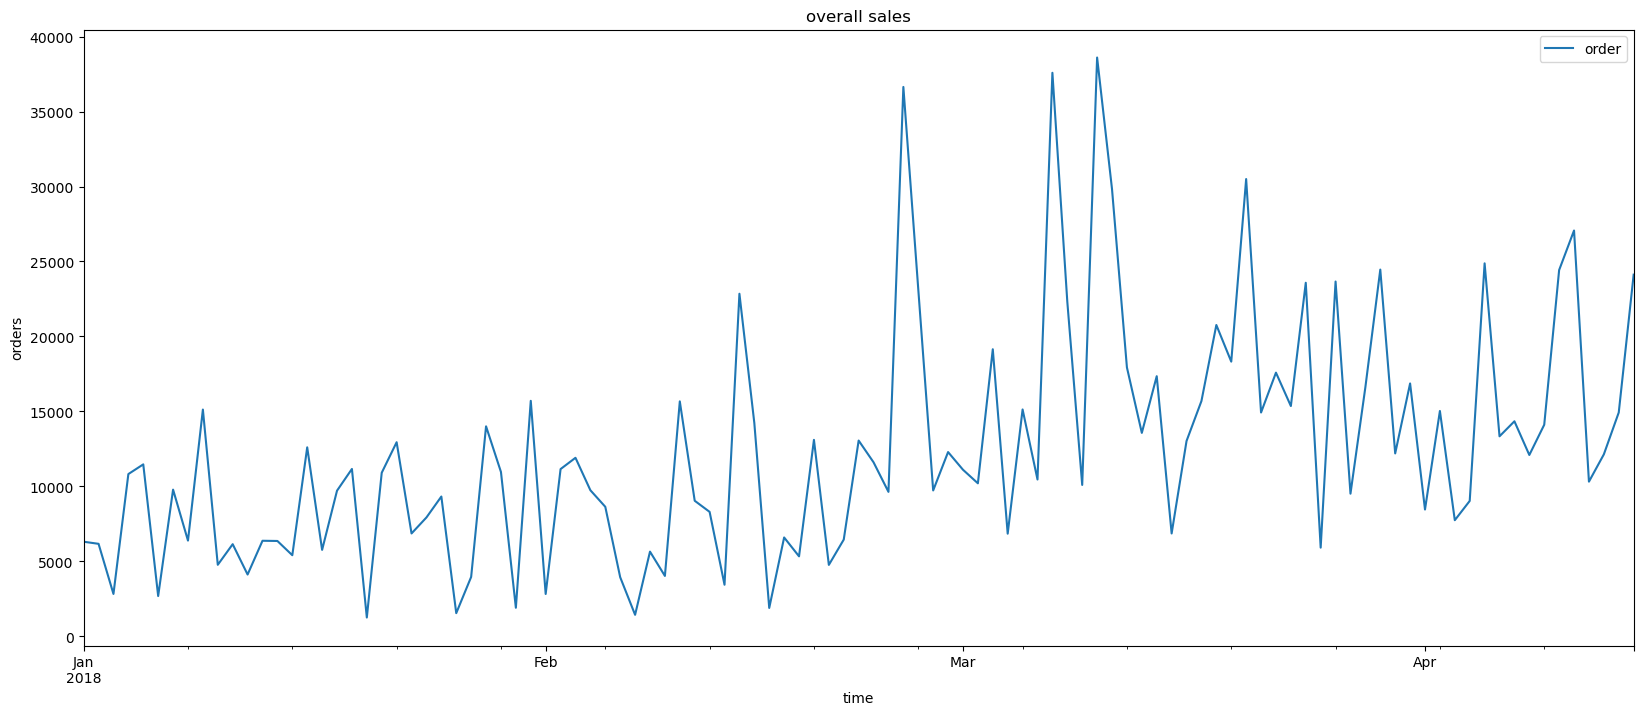

In [11]:
sorted_df.plot( "time" , "order",figsize=(20, 8))
plt.xlabel('time')
plt.ylabel('orders')
plt.title('overall sales')

plt.show()

In [12]:
# splitting into test and training datasets
train_df = sorted_df.loc[:89] # 3 months data
test_df = sorted_df.loc[90:]  # next 14 days data

ts_decomp_df = train_df.set_index('time') # set date as index
ts_decomp_df['order'] = ts_decomp_df['order'].astype(float)


ts_decomp_df

,order,month,day,weekday
time,,,,
2018-01-01,6305.0,1,1,7
2018-01-02,6165.0,1,2,1
2018-01-03,2821.0,1,3,2
2018-01-04,10819.0,1,4,3
2018-01-05,11465.0,1,5,4
...,...,...,...,...
2018-03-21,14924.0,3,21,2
2018-03-22,17584.0,3,22,3
2018-03-23,15356.0,3,23,4


## EXPLORATORY DATA ANALYSIS

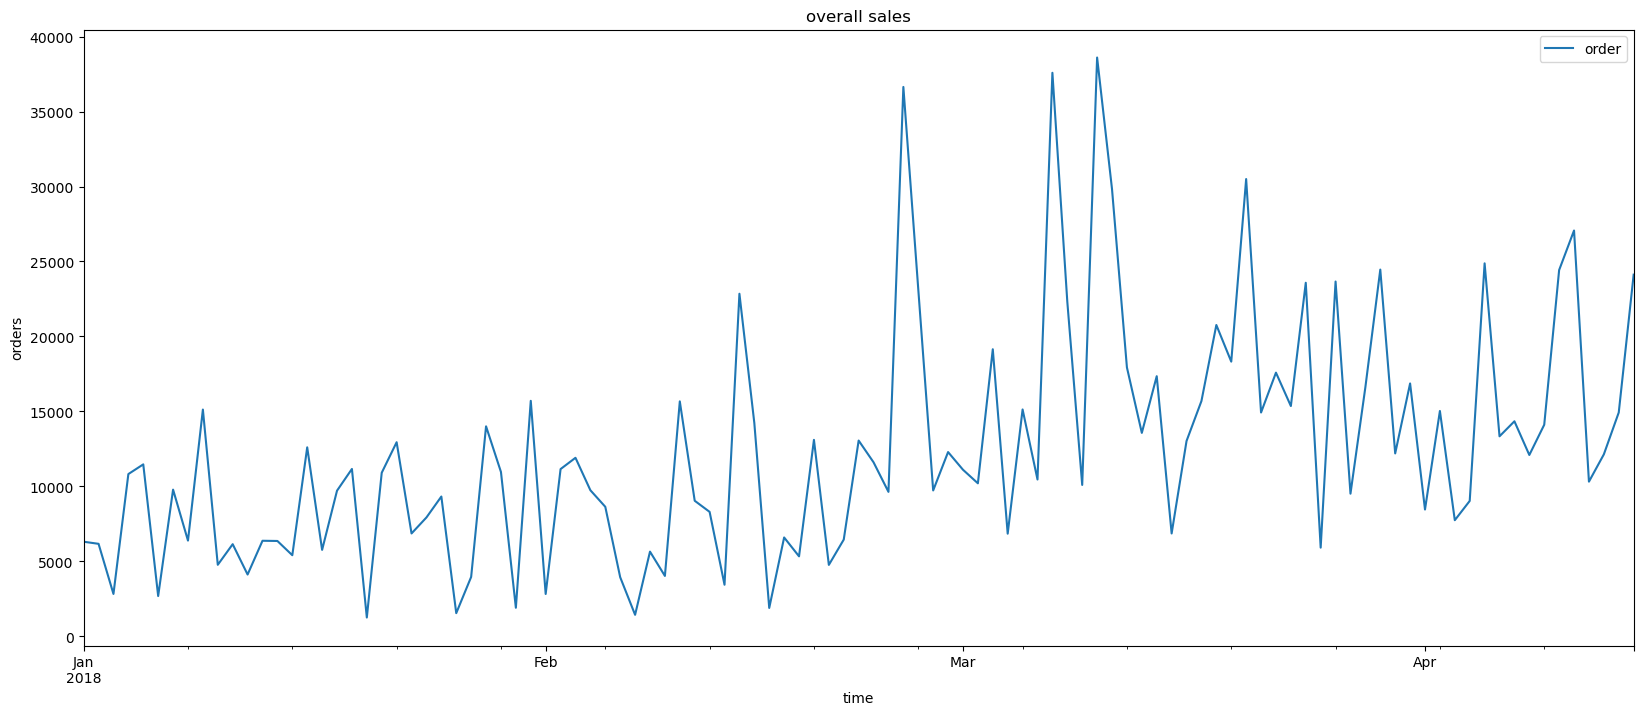

In [13]:
sorted_df.plot( "time" , "order",figsize=(20, 8))
plt.xlabel('time')
plt.ylabel('orders')
plt.title('overall sales')

plt.show()

In [14]:
# splitting into test and training datasets
train_df = sorted_df.loc[:89] # 3 months data
test_df = sorted_df.loc[90:]  # next 14 days data

ts_decomp_df = train_df.set_index('time') # set date as index
ts_decomp_df['order'] = ts_decomp_df['order'].astype(float)


ts_decomp_df

,order,month,day,weekday
time,,,,
2018-01-01,6305.0,1,1,7
2018-01-02,6165.0,1,2,1
2018-01-03,2821.0,1,3,2
2018-01-04,10819.0,1,4,3
2018-01-05,11465.0,1,5,4
...,...,...,...,...
2018-03-21,14924.0,3,21,2
2018-03-22,17584.0,3,22,3
2018-03-23,15356.0,3,23,4


<Figure size 640x480 with 0 Axes>

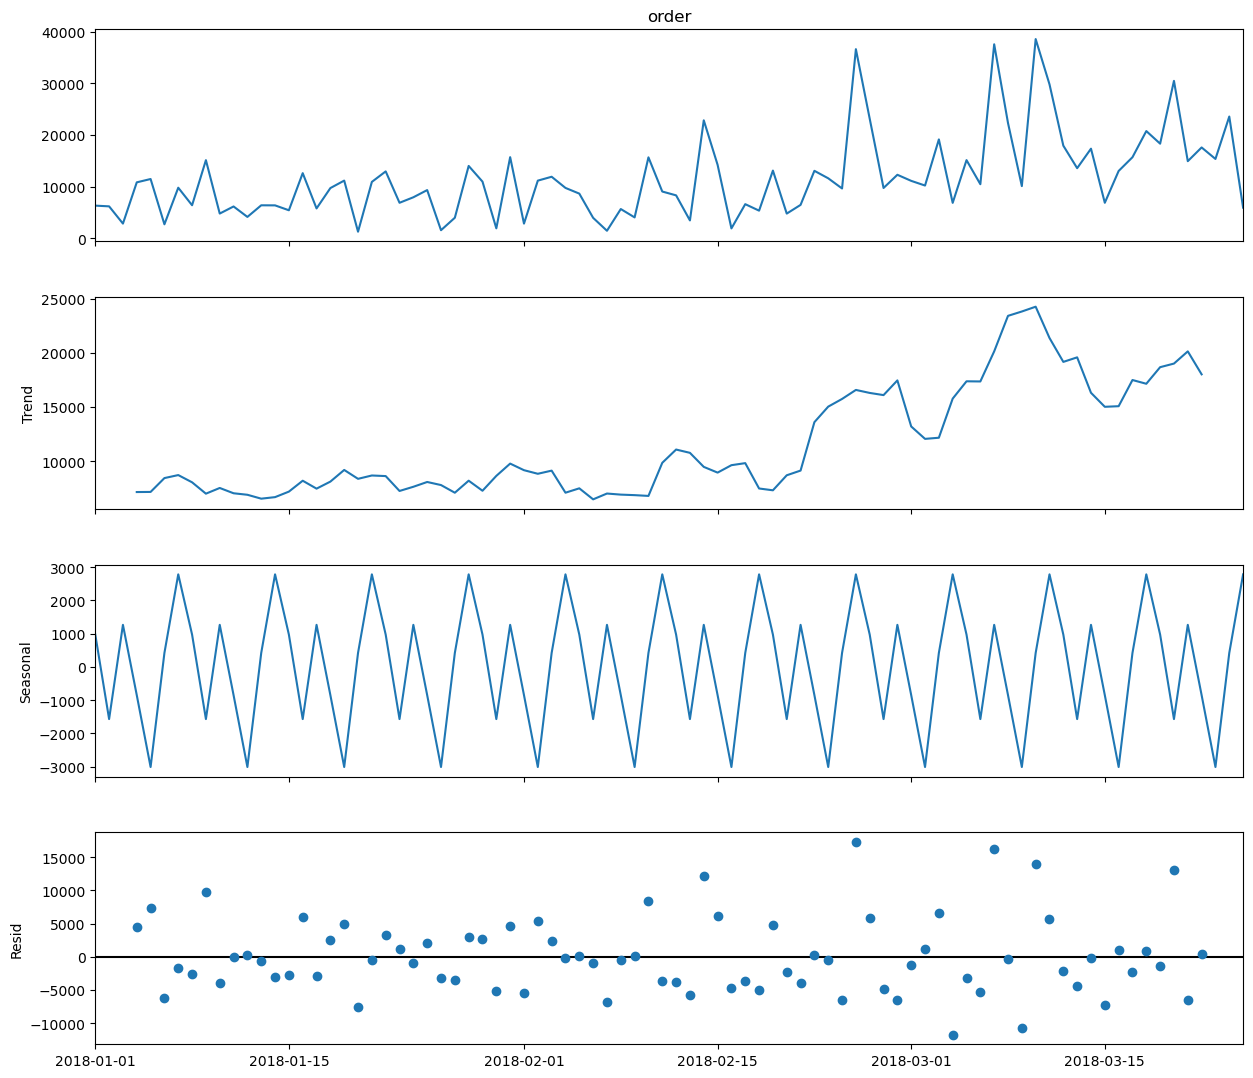

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(ts_decomp_df['order'])
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

# MODEL BUILDING 

### Simple Exponential Smoothing

In [16]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['order'].ewm(alpha=alpha,adjust=False).mean()
df['SES12'] = SimpleExpSmoothing(df['order']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

,time,order,month,day,weekday,EWMA12,SES12
0,2018-01-01,6305,1,1,7,6305.000000,6305.000000
1,2018-01-02,6165,1,2,1,6283.461538,6283.461538
2,2018-01-03,2821,1,3,2,5750.775148,5750.775148
3,2018-01-04,10819,1,4,3,6530.502048,6530.502048
4,2018-01-05,11465,1,5,4,7289.655579,7289.655579


In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['order'], trend='add').fit().fittedvalues.shift(-1)
df.head()

C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,time,order,month,day,weekday,EWMA12,SES12,DESadd12
0,2018-01-01,6305,1,1,7,6305.000000,6305.000000,6490.474595
1,2018-01-02,6165,1,2,1,6283.461538,6283.461538,6781.749699
2,2018-01-03,2821,1,3,2,5750.775148,5750.775148,6614.448676
3,2018-01-04,10819,1,4,3,6530.502048,6530.502048,7463.005804
4,2018-01-05,11465,1,5,4,7289.655579,7289.655579,8298.758464


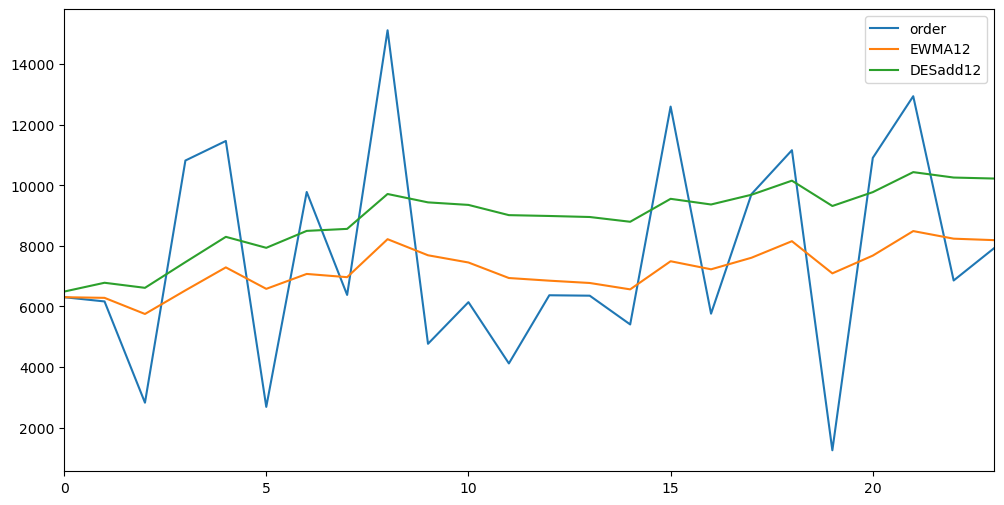

In [18]:
df[['order','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [19]:
df['DESmul12'] = ExponentialSmoothing(df['order'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,time,order,month,day,weekday,EWMA12,SES12,DESadd12,DESmul12
0,2018-01-01,6305,1,1,7,6305.000000,6305.000000,6490.474595,6519.646421
1,2018-01-02,6165,1,2,1,6283.461538,6283.461538,6781.749699,6827.170814
2,2018-01-03,2821,1,3,2,5750.775148,5750.775148,6614.448676,6470.178663
3,2018-01-04,10819,1,4,3,6530.502048,6530.502048,7463.005804,7624.289413
4,2018-01-05,11465,1,5,4,7289.655579,7289.655579,8298.758464,8783.440099


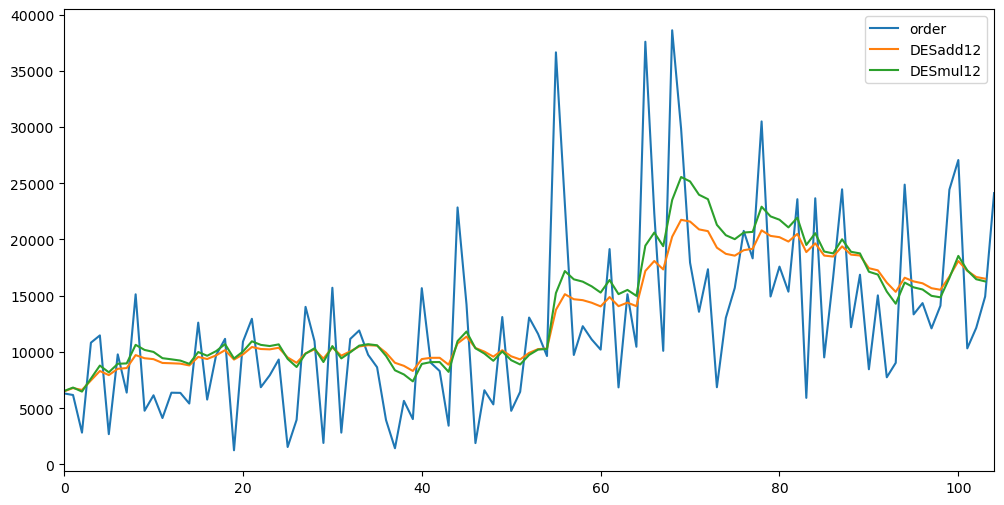

In [20]:
df[['order','DESadd12','DESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [21]:
df['TESmul12'] = ExponentialSmoothing(df['order'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,time,order,month,day,weekday,EWMA12,SES12,DESadd12,DESmul12,TESmul12
0,2018-01-01,6305,1,1,7,6305.000000,6305.000000,6490.474595,6519.646421,5684.015058
1,2018-01-02,6165,1,2,1,6283.461538,6283.461538,6781.749699,6827.170814,4534.108159
2,2018-01-03,2821,1,3,2,5750.775148,5750.775148,6614.448676,6470.178663,4389.043419
3,2018-01-04,10819,1,4,3,6530.502048,6530.502048,7463.005804,7624.289413,8291.281735
4,2018-01-05,11465,1,5,4,7289.655579,7289.655579,8298.758464,8783.440099,9470.538770


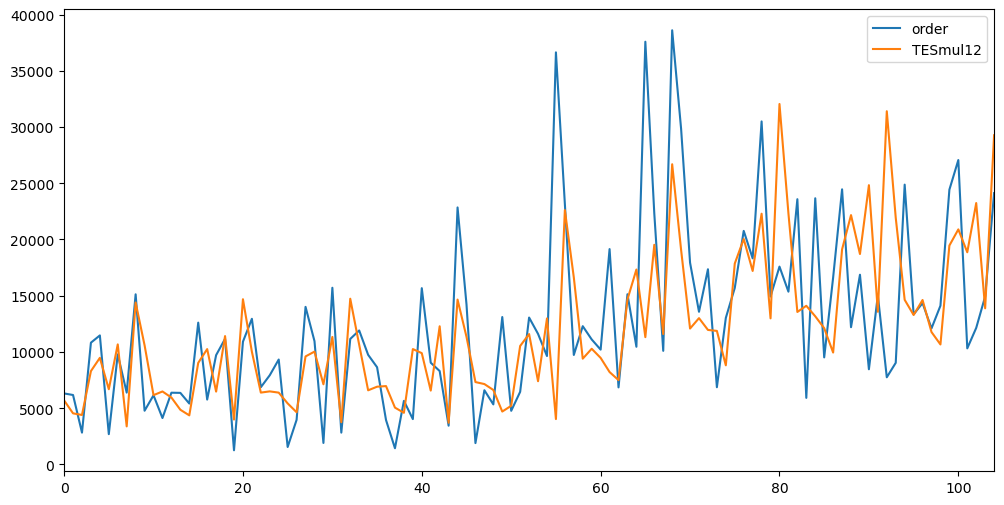

In [22]:
df[['order','TESmul12']].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

In [23]:
df['TESadd12'] = ExponentialSmoothing(df['order'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
df.head()

C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


,time,order,month,day,weekday,EWMA12,SES12,DESadd12,DESmul12,TESmul12,TESadd12
0,2018-01-01,6305,1,1,7,6305.000000,6305.000000,6490.474595,6519.646421,5684.015058,5520.119050
1,2018-01-02,6165,1,2,1,6283.461538,6283.461538,6781.749699,6827.170814,4534.108159,4682.462687
2,2018-01-03,2821,1,3,2,5750.775148,5750.775148,6614.448676,6470.178663,4389.043419,3805.124979
3,2018-01-04,10819,1,4,3,6530.502048,6530.502048,7463.005804,7624.289413,8291.281735,7909.863136
4,2018-01-05,11465,1,5,4,7289.655579,7289.655579,8298.758464,8783.440099,9470.538770,10230.188760


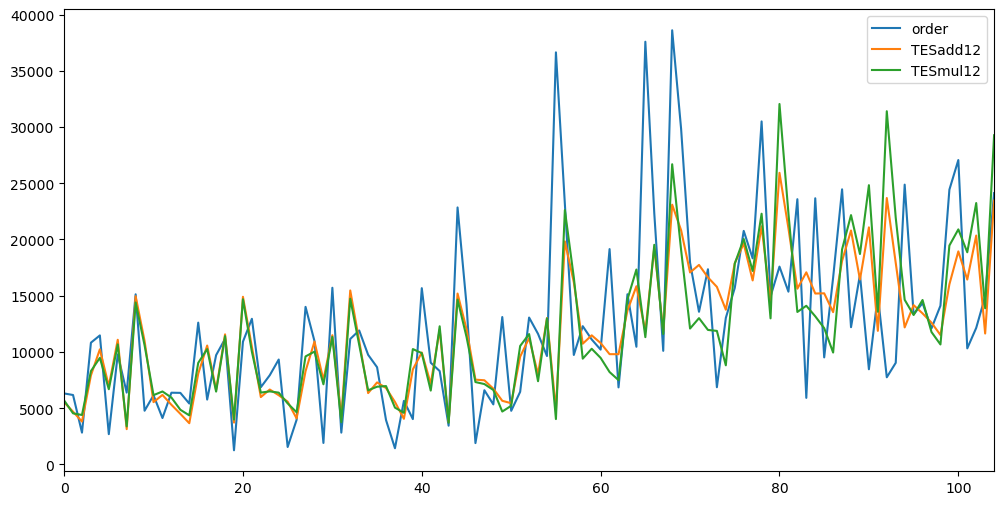

In [24]:
df[['order','TESadd12','TESmul12']].iloc[:].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

### ARIMA MODEL ( USING ML)

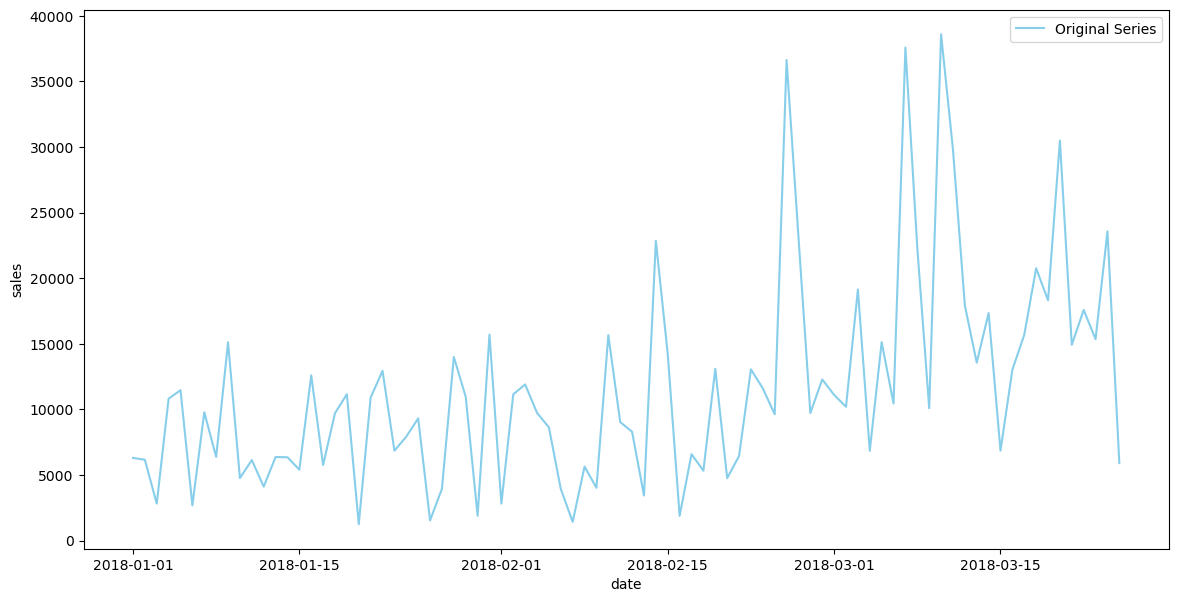

Test statistic = -0.813
P-value = 0.815
Critical values :
	1%: -3.5219803175527606 - The data is not stationary with 99% confidence
	5%: -2.9014701097664504 - The data is not stationary with 95% confidence
	10%: -2.58807215485756 - The data is not stationary with 90% confidence


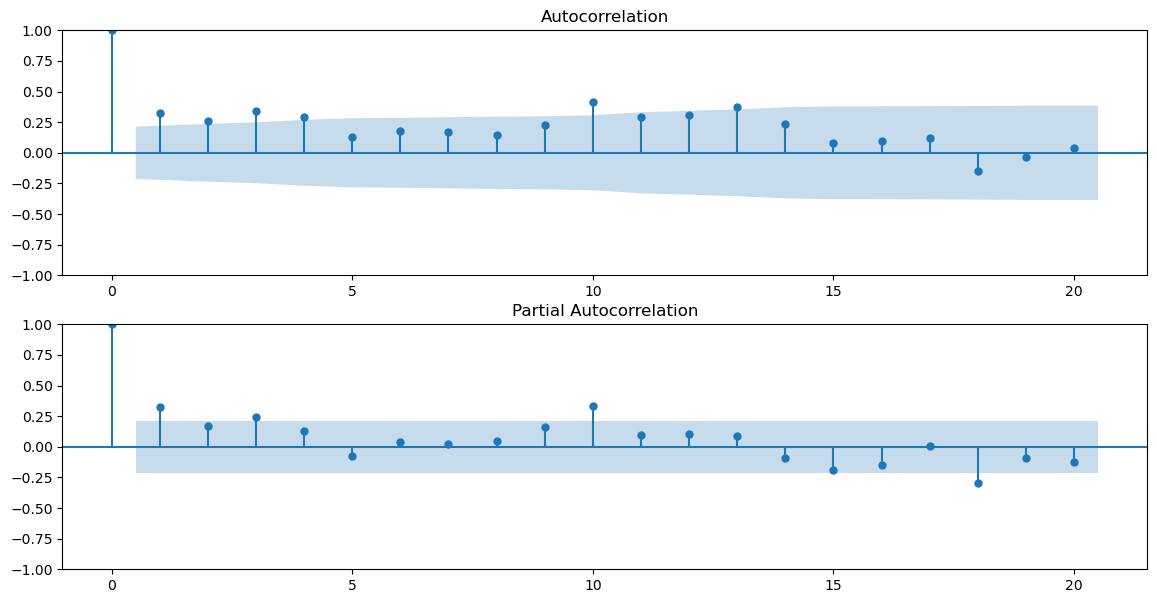

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# step 1 : check for stationarity

arima_df = train_df[['time', 'order']].set_index('time')
arima_test_df = test_df[['time', 'order']].set_index('time')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=90).mean()
    rollstd = timeseries.rolling(window=90).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')

    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()


     # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)




test_stationarity(arima_df.order)

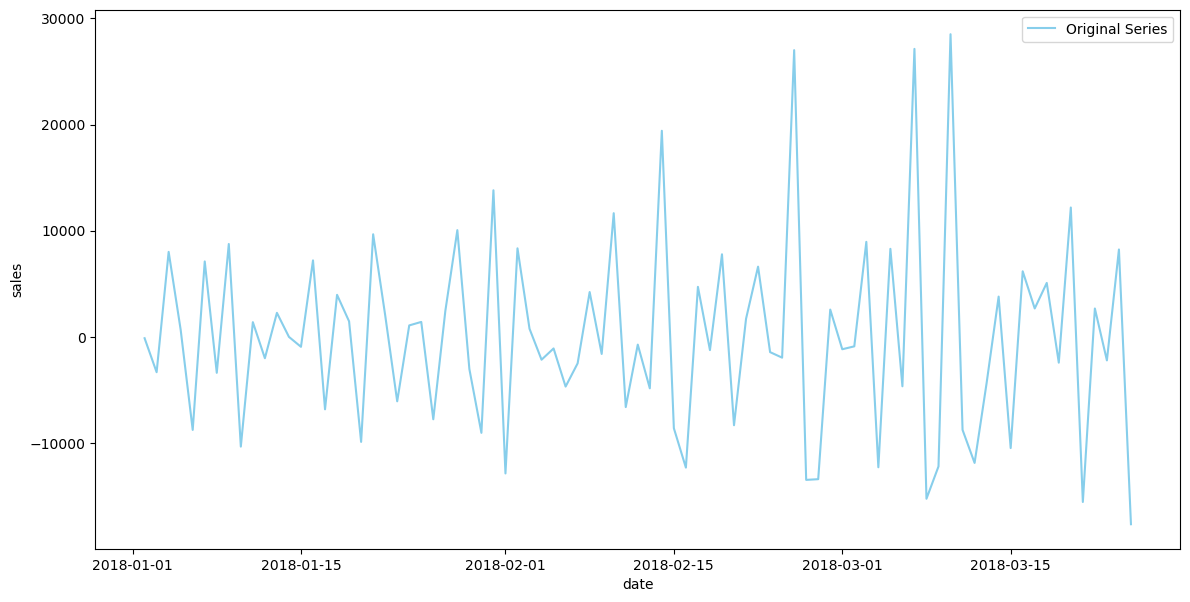

Test statistic = -5.324
P-value = 0.000
Critical values :
	1%: -3.526004646825607 - The data is  stationary with 99% confidence
	5%: -2.9032002348069774 - The data is  stationary with 95% confidence
	10%: -2.5889948363419957 - The data is  stationary with 90% confidence


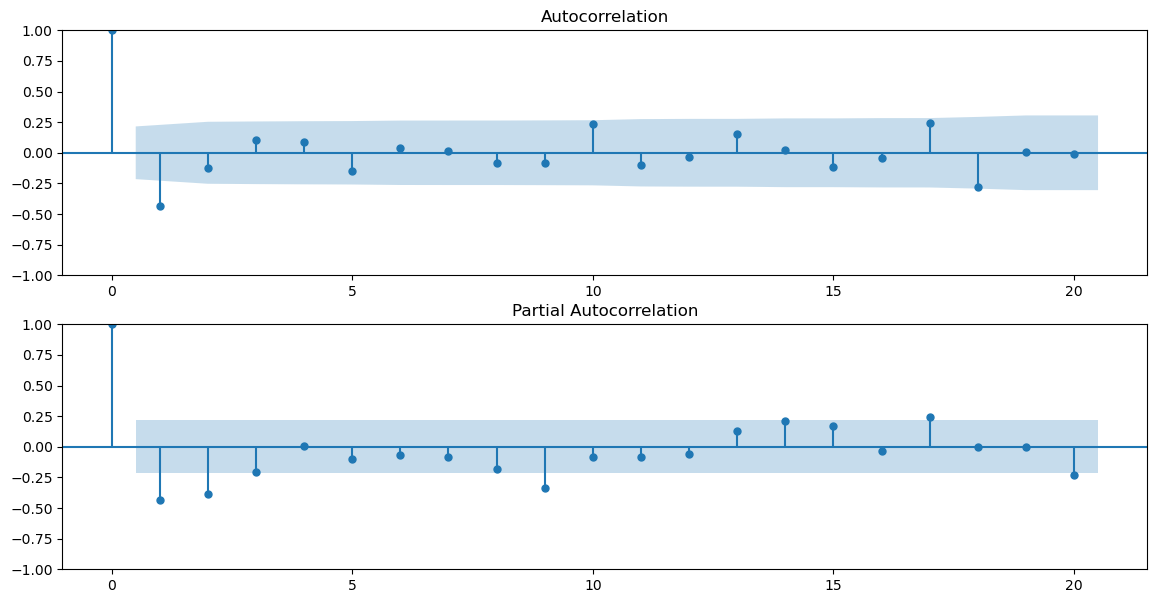

In [26]:
# STEP 2: MAKE THE SERIES STATIONARY

first_difference = arima_df.order - arima_df.order.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.order)

In [27]:
# ARIMA MODEL

from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(arima_df.order, order=(5,1,1)).fit() #( AR = 6 , I =1 , MA=1)
print(arima_model.summary())

C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  order   No. Observations:                   84
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -852.822
Date:                Fri, 10 May 2024   AIC                           1719.645
Time:                        02:45:55   BIC                           1736.577
Sample:                    01-01-2018   HQIC                          1726.447
                         - 03-25-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0163      0.188      0.087      0.931      -0.352       0.384
ar.L2         -0.0461      0.224     -0.205      0.837      -0.486       0.394
ar.L3          0.0724      0.142      0.509      0.6

In [50]:
arima = df.loc[:90]
arima_test_df = df.iloc[90:]

In [51]:
start=len(train)
end=len(train)+len(test)-1
predictionsA = arima_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(5,1,1) Predictions')

In [52]:
# first  week actual sales
sum_of_first_week = test["order"].iloc[0:7].sum()
print("THE TOTAL SALES FOR THE FIRST WEEK (1/4/2018-7/4/2018):",sum_of_first_week)

THE TOTAL SALES FOR THE FIRST WEEK (1/4/2018-7/4/2018): 92799


In [53]:
# first  week predicted sales
predicted_sum_of_first_week = predictionsA.iloc[0:7].sum()
print("PREDICTED SALES FOR THE FIRST WEEK :",int(predicted_sum_of_first_week))

PREDICTED SALES FOR THE FIRST WEEK : 120698


In [54]:
# first week error
error_first_week=(predicted_sum_of_first_week-sum_of_first_week)/sum_of_first_week
print("error between first week's predicted and actual sales ", error_first_week*100,"%")

error between first week's predicted and actual sales  30.064975105024587 %


In [55]:
# second week predicted sales
sum_of_second_week = test["order"].iloc[7:].sum()
print("THE TOTAL SALES FOR THE SECOND WEEK (8/4/2018-14/4/2018):",sum_of_second_week )

THE TOTAL SALES FOR THE SECOND WEEK (8/4/2018-14/4/2018): 139181


In [56]:
predicted_sum_of_second_week = predictionsA.iloc[7:].sum()
print("PREDICTED SALES FOR THE SECOND WEEK :",int(predicted_sum_of_second_week))

PREDICTED SALES FOR THE SECOND WEEK : 138070


In [57]:
# second week error
error_second_week=(predicted_sum_of_second_week-sum_of_second_week)/sum_of_second_week
print("error between seoncd week's predicted and actual sales ", error_second_week*100,"%")

error between seoncd week's predicted and actual sales  -0.798010291855027 %


In [58]:
# average error 
avg_error=(error_first_week+error_second_week)/2
print("AVERAGE ERROR",avg_error*100,"%")

AVERAGE ERROR 14.63348240658478 %


## improving the error by using sarima model

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [29]:
train = df.loc[:90]
test = df.iloc[90:]

In [38]:
#creating Sarima model
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
model = SARIMAX(train['order'],order=(5,1,1),seasonal_order=(5,1,1,30)) # seasonality=30 because analysing monthly seasonal trends ie sales in Jan , feb , march to predict april sales 
results = model.fit()
results.summary()

C:\Users\avija\Documents\ml_project\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              order   No. Observations:                   91
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 30)   Log Likelihood                -633.299
Date:                            Fri, 10 May 2024   AIC                           1292.598
Time:                                    02:48:23   BIC                           1319.824
Sample:                                         0   HQIC                          1303.247
                                             - 91                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0022      0.587     -0.004      0.997      -1.153       1.148
ar.L2          0.0178      0.524      0.034      0.973      -1.009       1.045
ar.L3          0.0513      0.427      0.120      0.904      -0.786       0.889
ar.L4          0.0431      0.468      0.092      0.927      -0.874       0.960
ar.L5         -0.2046      0.423     -0.484      0.628      -1.033       0.624
ma.L1         -0.8915      0.568     -1.569      0.117      -2.005       0.222
ar.S.L30      -0.2927   1.42e+05  -2.06e-06      1.000   -2.78e+05    2.78e+05
ar.S.L60       0.6149   1.39e+05   4.43e-06      1.000   -2.72e+05    2.72e+05
ar.S.L90       0.0107   3.58e+04   2.99e-07      1.000   -7.01e+04    7.01e+04
ar.S.L120      0.0193   1.22e+04   1.58e-06      1.000   -2.38e+04    2.38e+04
ar.S.L150   7.369e-06   3.61e+04   2.04e-10      1.000   -7.07e+04    7.07e+04
ma.S.L30      -0.6860   1.42e+05  -4.83e-06      1.000   -2.79e+05    2.79e+05
sigma2       1.49e+08     24.310   6.13e+06      0.000    1.49e+08    1.49e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                17.03
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             0.96
Prob(H) (two-sided):                  0.35   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.55e+24. Standard errors may be unstable.
"""

In [41]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('')

# weekly sales  predictions

In [42]:
# first  week actual sales 
sum_of_first_week = test["order"].iloc[0:7].sum()
print("THE TOTAL SALES FOR THE FIRST WEEK (1/4/2018-7/4/2018):",sum_of_first_week)


THE TOTAL SALES FOR THE FIRST WEEK (1/4/2018-7/4/2018): 92799


In [43]:
# first  week predicted sales
predicted_sum_of_first_week = predictions.iloc[0:7].sum()
print("PREDICTED SALES FOR THE FIRST WEEK :",int(predicted_sum_of_first_week))

PREDICTED SALES FOR THE FIRST WEEK : 109576


In [44]:
# first week error
error_first_week=(predicted_sum_of_first_week-sum_of_first_week)/sum_of_first_week
print("error between first week's predicted and actual sales ", error_first_week*100,"%")

error between first week's predicted and actual sales  18.07913628047711 %


In [45]:
# second week predicted sales
sum_of_second_week = test["order"].iloc[7:].sum()
print("THE TOTAL SALES FOR THE SECOND WEEK (8/4/2018-14/4/2018):",sum_of_second_week )

THE TOTAL SALES FOR THE SECOND WEEK (8/4/2018-14/4/2018): 139181


In [46]:
predicted_sum_of_second_week = predictions.iloc[7:].sum()
print("PREDICTED SALES FOR THE SECOND WEEK :",int(predicted_sum_of_second_week))

PREDICTED SALES FOR THE SECOND WEEK : 149401


In [47]:
# second week error
error_second_week=(predicted_sum_of_second_week-sum_of_second_week)/sum_of_second_week
print("error between seoncd week's predicted and actual sales ", error_second_week*100,"%")


error between seoncd week's predicted and actual sales  7.343057467320661 %


In [48]:
# average error 
avg_error=(error_first_week+error_second_week)/2
print("AVERAGE ERROR",avg_error*100,"%")

AVERAGE ERROR 12.711096873898883 %
